In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib.colors import Normalize
%matplotlib inline
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt
import collections

import instaseis

def nearest_power_2(x):
    return 2**(x-1).bit_length()


In [3]:
# Normal length
db = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur005km-00pMS-hQ_hyd30km_2s')
db_short = 'ice5'
# Long DB
# db = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur020km-00pMS-hQ_hyd30km_5s')
# db = instaseis.open_db('http://instaseis.ethz.ch/icy_ocean_worlds/Eur020km-00pMS-hQ_hyd30km_2s')
# db_short = 'ice20'


dist = 60.
rec = instaseis.Receiver(latitude=90 - dist, longitude=0, station='EUR')
src = instaseis.Source.from_strike_dip_rake(latitude=90, 
                                            longitude=0, M0=100e13, 
                                            depth_in_m=5000, strike=123, rake=75, dip=60)
src.set_sliprate_dirac(dt=db.info.dt, nsamp=100)
print(src)
st = db.get_seismograms(src, rec, components='RTZ', kind='displacement',
                        reconvolve_stf=True, remove_source_shift=False)

/Users/panning/anaconda/envs/obspy3/lib/python3.6/site-packages/instaseis/database_interfaces/remote_instaseis_db.py:60: InstaseisWarning: Instaseis versions on server (1.1.1-5-g7836) and on your local client (1.1.1) differ and thus things might not work as expected.
  warnings.warn(msg, InstaseisWarning)


Instaseis Source:
	Origin Time      : 1970-01-01T00:00:00.000000Z
	Longitude        :    0.0 deg
	Latitude         :   90.0 deg
	Depth            : 5.0e+00 km km
	Moment Magnitude :   4.00
	Scalar Moment    :   1.00e+15 Nm
	Mrr              :   8.37e+14 Nm
	Mtt              :  -3.84e+14 Nm
	Mpp              :  -4.53e+14 Nm
	Mrt              :   4.76e+14 Nm
	Mrp              :  -1.55e+14 Nm
	Mtp              :   4.73e+14 Nm



/Users/panning/anaconda/envs/obspy3/lib/python3.6/site-packages/numpy/ma/core.py:3194: ComplexWarning: Casting complex values to real discards the imaginary part
  output = self._data.astype(newtype).view(type(self))


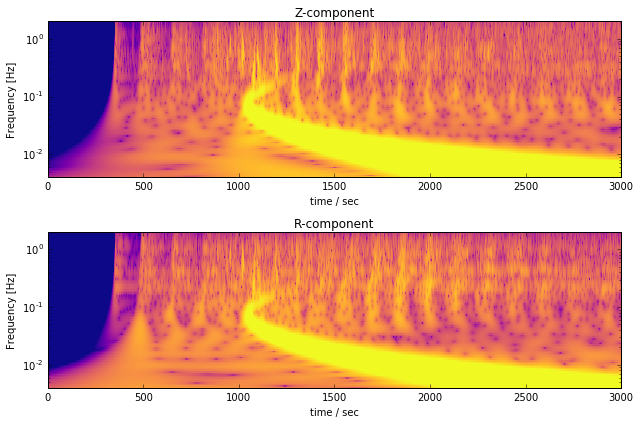

In [4]:
tr = st[0]
axnum = 210
fig = plt.figure(figsize=(9,6))
for chan in ['Z', 'R']:
    comp = '*%s' % chan
    tr_comb = st.select(channel=comp)[0]

    npts = tr_comb.stats.npts
    dt = tr_comb.stats.delta
    t = np.linspace(0, dt * npts, npts)
    f_min = 1./250
    f_max = 2.

    scalogram = cwt(tr_comb.data, dt, 6, f_min, f_max, nf=100)
   
    axnum += 1
    ax = fig.add_subplot(axnum)

    x, y = np.meshgrid(t,
                       np.logspace(np.log10(f_min), 
                                   np.log10(f_max), 
                                   scalogram.shape[0]))

    m = ax.pcolormesh(x, y, np.log10((scalogram)) * 15., 
                      cmap='plasma',
                      vmin=-150, vmax=-75)
    #ax_cbar = fig.add_axes((0.9, 0.05, 0.04, 0.77))
    #plt.colorbar(mappable=m, cax=ax_cbar)
    ax.set_title('%s-component' % chan)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_yscale('log')
    
    ax.set_ylim(f_min, f_max)
    ax.set_xlim(0,3000)
    ax.set_xlabel('time / sec')
plt.tight_layout()
fig.savefig('spec_M_%03.1f_%03d_deg_%s.png' % (src.moment_magnitude, dist, db_short), dpi=150)
plt.show()

/Users/panning/anaconda/envs/obspy3/lib/python3.6/site-packages/numpy/ma/core.py:3194: ComplexWarning: Casting complex values to real discards the imaginary part
  output = self._data.astype(newtype).view(type(self))


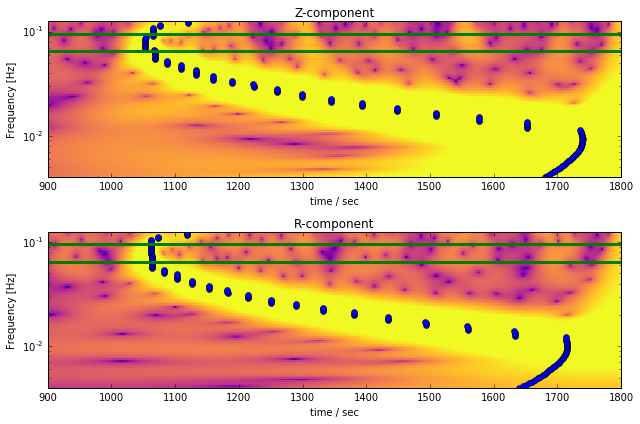

In [16]:
# Redo with data cut for flexural wave window and pick max values as function of frequency
t0 = 900.0
t1 = 1800.0
axnum = 210
fig2 = plt.figure(figsize=(9,6))
for chan in ['Z', 'R']:
    comp = '*%s' % chan
    tr_comb = st.select(channel=comp)[0]

    npts = tr_comb.stats.npts
    dt = tr_comb.stats.delta
    t = np.linspace(0, dt * npts, npts)
    mask = np.logical_and(t > t0, t < t1)
    tmask = t[mask]
    data = tr_comb.data[mask]
    f_min = 1./250
    f_max = 1./8
    f = np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0])

    scalogram = cwt(data, dt, 6, f_min, f_max, nf=100)
   
    axnum += 1
    ax = fig2.add_subplot(axnum)

    x, y = np.meshgrid(tmask, f)

    m = ax.pcolormesh(x, y, np.log10((scalogram)) * 15., 
                      cmap='plasma',
                      vmin=-125, vmax=-75)
    #ax_cbar = fig.add_axes((0.9, 0.05, 0.04, 0.77))
    #plt.colorbar(mappable=m, cax=ax_cbar)
    
    # Pick timing of peak values and plot
    tmax = tmask[scalogram.argmax(axis=1)]
    ax.plot(tmax,f,'bo')
    
    ax.set_title('%s-component' % chan)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_yscale('log')
    
    ax.set_ylim(f_min, f_max)
    ax.set_xlim(t0,t1)
    ax.set_xlabel('time / sec')
    
    # Add in lines around approximate group velocity max'
    maxf1 = 0.065
    maxf2 = 0.095
    ax.axhline(y=maxf1, color='g', linestyle='-', linewidth=3)
    ax.axhline(y=maxf2, color='g', linestyle='-', linewidth=3)
plt.tight_layout()
fig.savefig('spec_flexural_M_%03.1f_%03d_deg_%s.png' % (src.moment_magnitude, dist, db_short), dpi=150)
plt.show()

/Users/panning/anaconda/envs/obspy3/lib/python3.6/site-packages/numpy/ma/core.py:3194: ComplexWarning: Casting complex values to real discards the imaginary part
  output = self._data.astype(newtype).view(type(self))


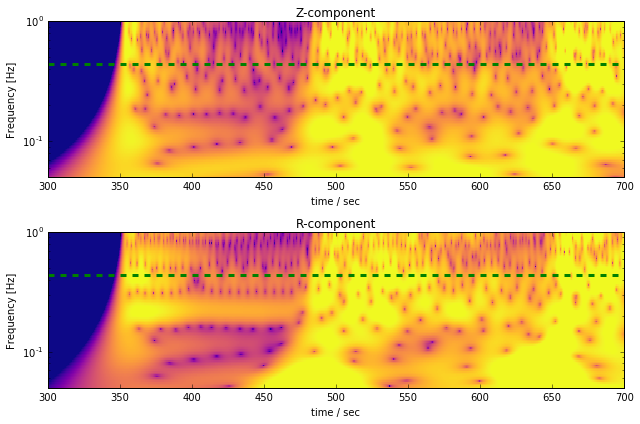

In [18]:
# Zoom in on Crary wave window now
t0 = 300.0
t1 = 700.0
axnum = 210
fig3 = plt.figure(figsize=(9,6))
for chan in ['Z', 'R']:
    comp = '*%s' % chan
    tr_comb = st.select(channel=comp)[0]

    npts = tr_comb.stats.npts
    dt = tr_comb.stats.delta
    t = np.linspace(0, dt * npts, npts)
    mask = np.logical_and(t > t0, t < t1)
    tmask = t[mask]
    data = tr_comb.data[mask]
    f_min = 1./20
    f_max = 1.
    f = np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0])

    scalogram = cwt(data, dt, 6, f_min, f_max, nf=100)
   
    axnum += 1
    ax = fig3.add_subplot(axnum)

    x, y = np.meshgrid(tmask, f)

    m = ax.pcolormesh(x, y, np.log10((scalogram)) * 15., 
                      cmap='plasma',
                      vmin=-150, vmax=-100)
    #ax_cbar = fig.add_axes((0.9, 0.05, 0.04, 0.77))
    #plt.colorbar(mappable=m, cax=ax_cbar)
    
    ax.set_title('%s-component' % chan)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_yscale('log')
    
    ax.set_ylim(f_min, f_max)
    ax.set_xlim(t0,t1)
    ax.set_xlabel('time / sec')
    
    # Add in a line at predicted Crary wave frequency
    f_crary = 0.44
    ax.axhline(y=f_crary, color='g', linestyle='--', linewidth=3)
    
plt.tight_layout()
fig.savefig('spec_crary_M_%03.1f_%03d_deg_%s.png' % (src.moment_magnitude, dist, db_short), dpi=150)
plt.show()